## Prediccion del precio de las propiedades

Vamos a utilizar la informacion de https://www.properati.com.ar/ correspondiente a Departamentos y PH de Capital Federal

#### Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configura la opción para desactivar la notación científica
pd.set_option('display.float_format', '{:.2f}'.format)

# Configurar opciones para poder visualizar todas las columnas
pd.set_option('display.max_columns', None)

In [2]:
# Importamos el dataset e imprimimos algunos registros
df = pd.read_csv("./properati_capital.csv")
df.sample(4)

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
822,789147,Q6glqSQVOoeVdyuwdaB3SQ==,Propiedad,2021-04-21,2021-07-16,2021-04-21,-34.60,-58.45,Argentina,Capital Federal,Villa Crespo,NaN,NaN,NaN,2.00,1.00,1.00,34.00,34.00,75000.00,USD,NaN,Departamento 2 ambientes OPORTUNIDAD.,Corredor Responsable: Monica Alejandra Mazza /...,Departamento,Venta
16705,187119,SJhbYvdR5g5NLWJ0c/SdIQ==,Propiedad,2020-07-29,2020-09-02,2020-07-29,-34.59,-58.44,Argentina,Capital Federal,Villa Crespo,NaN,NaN,NaN,3.00,2.00,1.00,62.00,58.00,165000.00,USD,NaN,DEPTO SEMIPISO 3 AMBIENTES VILLA CRESPO,Corredor Responsable: Maria Badino - CUCICBA ...,Departamento,Venta
36071,618870,eL1f3sDw4GWJaksnvDNpHA==,Propiedad,2020-12-03,2021-01-08,2020-12-03,-34.56,-58.46,Argentina,Capital Federal,Nuñez,NaN,NaN,NaN,1.00,0.00,1.00,NaN,NaN,89020.00,USD,NaN,"Departamento en Venta en Nuñez, Capital federa...",VENTA DEPARTAMENTO 1 AMBIENTE CABALLITO\n\nEmp...,Departamento,Venta
29123,156237,E/rP7aUfK7QD7WDpyXLxOA==,Propiedad,2020-05-31,2020-09-23,2020-05-31,NaN,NaN,Argentina,Capital Federal,Palermo,NaN,NaN,NaN,2.00,NaN,2.00,64.00,50.00,160000.00,USD,NaN,J Alvarez 1900 - U$D 160.000 - Departamento e...,Departamento de 3 ambientes con Patio.Living C...,Departamento,Venta


In [3]:
# Vemos las dimensiones del dataset
df.shape

(38656, 26)

### EDA

#### Distribucion del precio

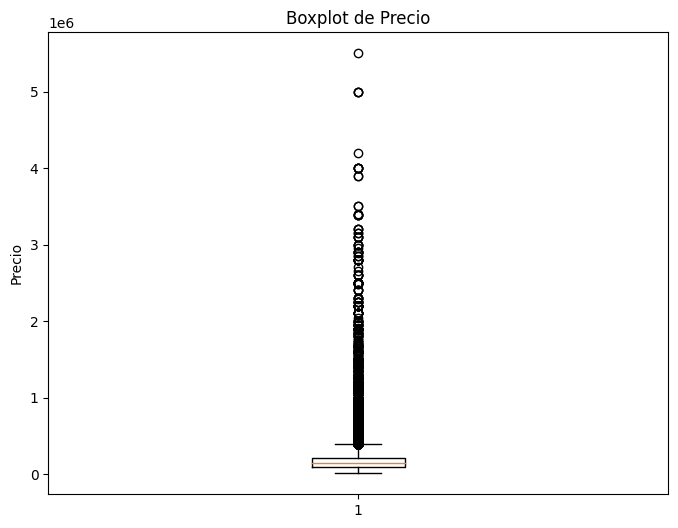

In [4]:
# Crear un boxplot para la columna "price"
plt.figure(figsize=(8, 6))  # Tamaño opcional del gráfico
plt.boxplot(df['price'])
plt.title('Boxplot de Precio')
plt.ylabel('Precio')
plt.show()

In [5]:
# Analizamos estadisticamente la columna precio
df.price.describe().T

count     38656.00
mean     195918.13
std      228924.52
min       10000.00
25%       95593.25
50%      139000.00
75%      215000.00
max     5500000.00
Name: price, dtype: float64

Como vemos, tenemos valores atípicos.

Por este motivo vamos a evaluar los percentiles 99 y 1

In [6]:
# Calcular el percentil 99 de la columna 'price'

percentil_99 = df['price'].quantile(0.99)
print(f"El valor del percentil 99 es: {percentil_99}")
percentil_01 = df['price'].quantile(0.01)
print(f"El valor del percentil 1 es: {percentil_01}")

El valor del percentil 99 es: 1190000.0
El valor del percentil 1 es: 47000.0


In [7]:
# Nos vamos a quedar con los registros que esten entre estos valores

df = df[(df['price'] > percentil_01) & (df['price'] < percentil_99)]
df.shape

(37857, 26)

## EDA

- Analizaremos las columnas que tenemos y sus tipos de datos
- Enriquecemos nuestro dataset con otra fuente de datos
- Seleccionaremos las variables relevantes
- Tratamiento de valores faltantes
- Tratamiendo de valores atípicos
- Creacion de nuevas variables


In [8]:
# Imprimimos los nombres de variables
df.columns

Index(['Unnamed: 0', 'id', 'ad_type', 'start_date', 'end_date', 'created_on',
       'lat', 'lon', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'price', 'currency',
       'price_period', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

In [9]:
# Eliminamos las variables "Unnamed: 0" y "id" ya que son variables keys del dataset y no nos aportan informacion

ids_vars = ["Unnamed: 0", "id"] # creo una lista de las variables que decidimos eliminar
df.drop(ids_vars, axis=1,inplace= True) # el parametro inplace nos permite guardar los nuevos cambios dentro de la variable existente
df.shape

(37857, 24)

Veamos ahora los tipos de datos de estas columnas

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37857 entries, 0 to 38655
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ad_type          37857 non-null  object 
 1   start_date       37857 non-null  object 
 2   end_date         37857 non-null  object 
 3   created_on       37857 non-null  object 
 4   lat              35862 non-null  float64
 5   lon              35862 non-null  float64
 6   l1               37857 non-null  object 
 7   l2               37857 non-null  object 
 8   l3               37727 non-null  object 
 9   l4               1071 non-null   object 
 10  l5               0 non-null      float64
 11  l6               0 non-null      float64
 12  rooms            35341 non-null  float64
 13  bedrooms         30495 non-null  float64
 14  bathrooms        35557 non-null  float64
 15  surface_total    22113 non-null  float64
 16  surface_covered  22143 non-null  float64
 17  price       

Vemos que existen variables con muchos valores nulos.

Hagamos este análisis de una manera mas precisa.

In [11]:
# Calculamos % los valores faltantes para cada una de las variables
miss = pd.DataFrame(df.isnull().mean(), columns=["Missing"])
perc_miss = miss.loc[miss.Missing > 0]
perc_miss.sort_values("Missing", ascending = False)

,Missing
l5,1.00
l6,1.00
price_period,1.00
l4,0.97
surface_total,0.42
surface_covered,0.42
bedrooms,0.19
rooms,0.07
bathrooms,0.06
lat,0.05


Observamos que las variables l6, l5, price_period y l4 contienen un alto % de valores faltantes.

Por este motivo vamos a eliminarlos de nuestro dataset

In [12]:
# Repetimos el método de eliminar columnas

vars_nulls = ["l6", "l5", "l4", "price_period"] 
df.drop(vars_nulls, axis = 1, inplace= True )
df.shape 

(37857, 20)

In [13]:
df.tail(3)

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
38653,Propiedad,2020-12-31,2021-01-02,2020-12-31,-34.63,-58.44,Argentina,Capital Federal,Caballito,4.00,3.00,2.00,108.00,108.00,273060.00,USD,VENTA DEPARTAMENTO EN POZO EDIFICIO PREMIUM,Corredor Responsable: Ariel Champanier - C.U.C...,Departamento,Venta
38654,Propiedad,2021-04-30,9999-12-31,2021-04-30,-34.64,-58.49,Argentina,Capital Federal,Velez Sarsfield,1.00,1.00,1.00,NaN,NaN,68100.00,USD,"Departamento en Venta en Velez sarsfield, Capi...",Venta de Departamento 2 AMBIENTES en Velez Sar...,Departamento,Venta
38655,Propiedad,2020-09-26,2020-10-10,2020-09-26,NaN,NaN,Argentina,Capital Federal,Belgrano,2.00,1.00,1.00,47.00,47.00,199000.00,USD,Departamento a Estrenar dos ambientes.,"Hermoso departamento, en la mejor zona Bajo B...",Departamento,Venta


Sospechamos que existen columnas con un unico valor de dato.

Si es asi estas columnas no nos aportan informacion para nuestra futura prediccion

In [14]:
# Contamos la cantidad de valores unicos que tiene cada columna

for x in df.columns: 
    unique_vals = df[f"{x}"].nunique() # nunique() cuenta la cantidad de valores unicos que tiene una columna
    if unique_vals > 2: 
        None
    else:
        print(f'Variable {x}:', unique_vals)

Variable ad_type: 1
Variable l1: 1
Variable l2: 1
Variable currency: 1
Variable property_type: 2
Variable operation_type: 1


Podemos ver esto mismo usando el método value_counts()

In [15]:
# Vemos los valores para property_type y para l1

df.l1.value_counts(dropna=False)

Argentina    37857
Name: l1, dtype: int64

In [16]:
df.property_type.value_counts(dropna=False)

Departamento    33802
PH               4055
Name: property_type, dtype: int64

Property_type tiene sentido que solo tenga dos valores posibles ya que son los tipos de propiedades que queremos predecir.

Pero el resto de las variables que tienen valores unicos las eliminaremos.

In [17]:
unique_vars = ["ad_type", "l1", "l2", "currency", "operation_type"] 
df.drop(unique_vars, axis = 1, inplace= True)
df.head() 

,start_date,end_date,created_on,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,title,description,property_type
0,2020-07-06,2021-04-07,2020-07-06,-34.62,-58.48,Villa del Parque,2.00,1.00,1.00,NaN,NaN,89000.00,Galicia 2800 Depto 2 Ambientes Con Balcón Vill...,XINTEL(JUM-JUM-313) \n\nExcelente departament...,Departamento
1,2020-07-17,9999-12-31,2020-07-17,-34.62,-58.45,Caballito,3.00,2.00,2.00,NaN,NaN,190000.00,DEPARTAMENTO A ESTRENAR AL FRENTE CON COCHERA,EXCELENTE DPTO A ESTRENAR AL FRENTE CON COCHER...,Departamento
2,2020-06-19,2020-12-03,2020-06-19,-34.59,-58.43,Palermo,3.00,2.00,2.00,98.00,68.00,360000.00,Excelente departamento 4 ambientes con terraza...,Patio El Salvador . inicio de obra nmarzo 2019...,Departamento
3,2021-02-24,2021-03-01,2021-02-24,-34.58,-58.49,Villa Urquiza,4.00,4.00,1.00,118.00,96.00,285000.00,Venta depto 4 ambientes/terraza en V. Urquiza,Corredor Responsable: MARIANO AUFSEHER - CPI 4...,Departamento
4,2020-11-17,2021-04-13,2020-11-17,-34.62,-58.44,Caballito,2.00,11.00,1.00,61.00,52.00,145000.00,Departamento de 2 ambientes c terraza a estrenar,Corredor Responsable: MARCELO GRUNBAUM - CMCPS...,Departamento


Las variables "created_on", "start_date", "end_date" no son variables útiles para lo que queremos hacer --> las eliminamos

Se podrían crear variables muy relevantes para nuestro modelo a partir de la latitud y la longitud pero no las utilizaremos en nuestro entrenamiento.

Algunas de las cosas que se pueden hacer pueden encontrar las en este post: https://python.plainenglish.io/how-to-use-geo-location-for-feature-engineering-using-near-by-points-of-interest-563752e6ad26

In [18]:
drop_vars = ["created_on", "start_date", "end_date", "lat", "lon"]
df.drop(drop_vars, axis=1, inplace= True)
df.shape

(37857, 10)

#### Enriquecimiento del dataset con una fuente externa

Importamos un dataset que extraemos de https://mudafy.com.ar/

Este contiene la informacion del precio promedio de m2 por barrio

In [19]:
df_m2 = pd.read_excel("./precio_prom_m2.xlsx")

In [20]:
df_m2.head()

,Barrio,Comuna,Valor m2 (USD)
0,Recoleta,Comuna 2,1978
1,Coghlan,Comuna 12,1803
2,Villa Urquiza,Comuna 12,1939
3,Saavedra,Comuna 12,1916
4,Villa Pueyrredon,Comuna 12,1677


In [21]:
df_m2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Barrio          46 non-null     object
 1   Comuna          46 non-null     object
 2   Valor m2 (USD)  46 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ KB


In [22]:
# Joineamos los dos df para traer las nuevas variables que seran de utildiad

df_merged = pd.merge(df, df_m2, left_on = "l3", right_on = "Barrio", how= 'left')
df_merged.drop(["Barrio"], axis=1, inplace=True)  # Eliminamos la variable Barrio ya que nos proporciona el mismo tipo de info que l3
df_merged.rename(columns={"Valor m2 (USD)":"valor_m2"}, inplace=True) # Renombramos la variable por un nombre mas sencillo
df_merged.shape

(37857, 12)

#### Tratamiento de valores faltantes

Volvemos hacer el análisis de missings para ver que tan poblada estan las nuevas variables

In [23]:
miss = pd.DataFrame(df_merged.isnull().mean(), columns=["Missing"])
perc_miss = miss.loc[miss.Missing > 0]
perc_miss.sort_values("Missing", ascending = False)

,Missing
surface_total,0.42
surface_covered,0.42
bedrooms,0.19
Comuna,0.09
valor_m2,0.09
rooms,0.07
bathrooms,0.06
l3,0.00


In [24]:
# Analizamos algunos valores estadísticos de las variables "bathrooms", "rooms", "bedrooms", "surface_total", "surface_covered", "valor_m2"

df_merged[["bathrooms", "rooms", "bedrooms", "surface_total", "surface_covered", "valor_m2"]].describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,35557.00,1.41,0.69,1.00,1.00,1.00,2.00,9.00
rooms,35341.00,2.54,1.23,1.00,2.00,2.00,3.00,22.00
bedrooms,30495.00,1.77,1.39,0.00,1.00,2.00,2.00,153.00
surface_total,22113.00,121.78,1617.91,11.00,43.00,61.00,92.00,140380.00
surface_covered,22143.00,92.15,969.40,1.00,40.00,55.00,80.00,63660.00
valor_m2,34441.00,1814.67,328.54,899.00,1570.00,1861.00,2020.00,3993.00


Vemos que existen outliers para algunas de estas columnas, pero esto lo analizaremos luego.

Ahora nos concentraremos en la imputacion de valores faltantes aplicando distintas estrategias de imputacion segun la variable

In [25]:
# Para bathrooms, room y bedrooms --> imputaremos con la mediana ya que deberian ser valores enteros


# Calculamos la media de cada columna
median_bathrooms = df_merged['bathrooms'].median()
median_rooms = df_merged['rooms'].median()
median_bedrooms = df_merged['bedrooms'].median()

# Imprime las medias
print(f"Mediana de 'bathrooms': {median_bathrooms}")
print(f"Mediana de 'rooms': {median_rooms}")
print(f"Mediana de 'bedrooms': {median_bedrooms}")


Mediana de 'bathrooms': 1.0
Mediana de 'rooms': 2.0
Mediana de 'bedrooms': 2.0


In [26]:
# Imputamos los valores

df_merged['bathrooms'].fillna(median_bathrooms, inplace=True)
df_merged['rooms'].fillna(median_rooms, inplace=True)
df_merged['bedrooms'].fillna(median_bedrooms, inplace=True)

In [27]:
# Como surface_total, surface_covered y valor_m2 pueden tomar valores decimales utilizamos la media para imputar sus nulos

# Calculamos las medias para cada columna
mean_surface_total = df_merged['surface_total'].mean()
mean_surface_covered = df_merged['surface_covered'].mean()
mean_valor_m2 = df_merged['valor_m2'].mean()

# Imprimimos las medias
print(f"Media de 'surface_total': {mean_surface_total}")
print(f"Media de 'surface_covered': {mean_surface_covered}")
print(f"Media de 'valor_m2': {mean_valor_m2}")

Media de 'surface_total': 121.77945100167322
Media de 'surface_covered': 92.15124418552138
Media de 'valor_m2': 1814.668186173456


In [28]:
# Imputamos los valores

df_merged['surface_total'].fillna(mean_surface_total, inplace=True)
df_merged['surface_covered'].fillna(mean_surface_covered, inplace=True)
df_merged['valor_m2'].fillna(mean_valor_m2, inplace=True)

In [29]:
# Verificamos los valores faltantes

miss = pd.DataFrame(df_merged.isnull().mean(), columns=["Missing"])
perc_miss = miss.loc[miss.Missing > 0]
perc_miss.sort_values("Missing", ascending = False)

,Missing
Comuna,0.09
l3,0.00


#### Tratamiento de valores atípicos/outliers

In [30]:
# Volvemos a imprimir algunas metricas estadísticas para "bathrooms", "rooms", "bedrooms", "surface_total", "surface_covered"

df_merged[["bathrooms", "rooms", "bedrooms", "surface_total", "surface_covered"]].describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,37857.00,1.38,0.68,1.00,1.00,1.00,2.00,9.00
rooms,37857.00,2.50,1.19,1.00,2.00,2.00,3.00,22.00
bedrooms,37857.00,1.82,1.25,0.00,1.00,2.00,2.00,153.00
surface_total,37857.00,121.78,1236.52,11.00,55.00,120.00,121.78,140380.00
surface_covered,37857.00,92.15,741.38,1.00,50.00,92.15,92.15,63660.00


Vamos a utilizar la tecnica de capping para no perder registros para nuestro entrenamiento

In [31]:
# Capping superior
# Lista de columnas a procesar
cap_sup_cols = ["bathrooms", "rooms", "bedrooms", "surface_total", "surface_covered"]

# Iteramos a través de las columnas y reemplazamos los valores que superan el percentil 99
for columna in cap_sup_cols:
    percentil_99 = np.percentile(df_merged[columna], 99)
    df_merged[columna] = np.where(df_merged[columna] > percentil_99, percentil_99, df_merged[columna])
    
df_merged[["bathrooms", "rooms", "bedrooms", "surface_total", "surface_covered"]].describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,37857.00,1.38,0.66,1.00,1.00,1.00,2.00,4.00
rooms,37857.00,2.49,1.13,1.00,2.00,2.00,3.00,6.00
bedrooms,37857.00,1.80,0.86,0.00,1.00,2.00,2.00,4.00
surface_total,37857.00,95.62,43.91,11.00,55.00,120.00,121.78,271.00
surface_covered,37857.00,77.00,32.46,1.00,50.00,92.15,92.15,211.00


In [32]:
# Capping inferior

cap_inf_cols = ["surface_total", "surface_covered"]

# Itera a través de las columnas y reemplaza los valores según la condición
for columna in cap_inf_cols:
    percentil_1 = np.percentile(df_merged[columna], 1)
    df_merged[columna] = np.where(df_merged[columna] < percentil_1, percentil_1, df_merged[columna])

df_merged[["bathrooms", "rooms", "bedrooms", "surface_total", "surface_covered"]].describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,37857.00,1.38,0.66,1.00,1.00,1.00,2.00,4.00
rooms,37857.00,2.49,1.13,1.00,2.00,2.00,3.00,6.00
bedrooms,37857.00,1.80,0.86,0.00,1.00,2.00,2.00,4.00
surface_total,37857.00,95.65,43.87,26.00,55.00,120.00,121.78,271.00
surface_covered,37857.00,77.04,32.37,25.00,50.00,92.15,92.15,211.00


#### Búsqueda de keywords en variables de texto

In [33]:
# Concatenamos las variables del titulo y la descripcion para trabajar con una unica variable

df_merged['title_descr'] = df_merged['description'] + ' ' + df_merged['title']
df_merged.drop(["description", "title"], axis=1, inplace=True) # eliminamos las variables originales

Utilizaremos la libreria regex que es de expresiones regulares.

Documentacion: https://docs.python.org/3/library/re.html

In [34]:
# Importamos la libreria re (regex) 
import re

# Definimos las palabras clave
keywords = ["sum", "pileta", "amenities", "cochera"]

# Crea una columna para cada palabra clave y asigna 0 como valor inicial
for keyword in keywords:
    df_merged[keyword] = 0

# Itera a través de las palabras clave y asigna 1 si se encuentra la palabra clave en 'title_descr'
for keyword in keywords:
    # La siguiente línea crea un patrón de búsqueda de expresión regular (regex) para la palabra clave actual.
    # - El patrón \b{}\\b busca la palabra clave completa como una palabra independiente.
    # - El flag re.IGNORECASE hace que la búsqueda sea insensible a mayúsculas y minúsculas.
    pattern = re.compile(r'\b{}\b'.format(keyword), flags=re.IGNORECASE) #
    df_merged[keyword] = df_merged['title_descr'].apply(lambda x: 1 if pattern.search(str(x)) else 0)

In [35]:
df_merged.shape

(37857, 15)

In [37]:
# Iteramos a través de las columnas creadas y realiza un value_counts para cada una

for keyword_column in keywords:
    value_counts_keyword = df_merged[keyword_column].value_counts()
    print(f"Value Counts para '{keyword_column}':")
    print(value_counts_keyword)
    print()

Value Counts para 'sum':
0    31303
1     6554
Name: sum, dtype: int64

Value Counts para 'pileta':
0    34128
1     3729
Name: pileta, dtype: int64

Value Counts para 'amenities':
0    31811
1     6046
Name: amenities, dtype: int64

Value Counts para 'cochera':
0    29815
1     8042
Name: cochera, dtype: int64



In [38]:
# Ahora que tenemos nuestras columnas creadas podemos eliminar la columna de texto
df_merged.drop(["title_descr"], axis= 1, inplace=True)

In [39]:

df_merged.shape

(37857, 14)

#### Variables Categóricas